<h1><center>League of Data</center></h1>
<center>Glenn Trace</center>


## Introduction

League of Legends (LoL) is a MOBA (Multiplayer Online Battle Arena) video game featuring two teams of five players battling in an arena-style map. LoL is the world's largest esport with an international competitive scene consisting of 12 leagues. The League of Legends Championship Series (LCS) is North America's league. It consists of 10 teams which compete against one another in a Spring and Summer split for a chance to qualify for the annual world championship. My goal is to use data science techniques to create a model based off of past LCS results that can accurately predict the outcome of professional LoL matches. 

## Abstract

I utilized data from past seasons of the LCS extracted from Oracles Elixir (https://oracleselixir.com/), a website run by a professional data scientist with a career in esports. The next step was to determine how I was going to train the models, and with which predictive features. Team winrate is a clear indicator of success, so I decided to create a new feature by dividing each teams total wins by their total games played. The next step was to use correlation matrices and other graphs to identify which features have the most significant impact on winrate. This process helped to inform me which features I should and should not include in the model. From there I applied linear regression and k-means clustering to visualize correlations between team stats and their respective winrate. I then utilized logistic regression to predict the winner of the current Spring 2022 split of the LCS.


## Imports

In [1]:
#import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from IPython import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

## Create Dataframes

In [2]:
# Import the datasets into dataframes
team = pd.read_csv("TeamData2017-2022.csv")

# Get rid of null values with a 0
team = team.replace("-",0)

# Get rid of the % in data for team DF
percentsTeam = ["GSPD", "FB%", "FT%", "F3T%", "HLD%", "FD%", "DRG%", "ELD%", "FBN%", "BN%", "LNE%", "JNG%"]
team[percentsTeam] = team[percentsTeam].replace({"%":""}, regex=True)

# Convert all objects to floats in team df and check
team[percentsTeam] = team[percentsTeam].astype(float, errors='raise')

team_clean = pd.DataFrame().assign(WinRate=team['W']/team['GP'], AGT = team['AGT'], KD=team['KD'], GPR=team['GPR'], 
                                   EGR=team['EGR'], MLR=team['MLR'], GD15 = team['GD15'], FB = team["FB%"], 
                                   FT = team["FT%"], F3T = team["F3T%"], HRLD=team['HLD%'],
                                   DRG=team['DRG%'],  ELD=team['ELD%'], FBN = team['FBN%'])

team_clean = team_clean.fillna(0)


finals = pd.read_csv("Team2022Final.csv")
finals = finals.replace("-",0)

finals[percentsTeam] = finals[percentsTeam].replace({"%":""}, regex=True)

finals = finals.fillna(0)

# Convert all objects to floats in team df and check
finals[percentsTeam] = finals[percentsTeam].astype(float, errors='raise')

finals_clean = pd.DataFrame().assign(WinRate=finals['W']/finals['GP'], AGT = finals['AGT'], KD=finals['KD'], GPR=finals['GPR'], 
                                   EGR=finals['EGR'], MLR=finals['MLR'], GD15 = finals['GD15'], FB = finals["FB%"], 
                                   FT = finals["FT%"], F3T = finals["F3T%"], HRLD=finals['HLD%'],
                                   DRG=finals['DRG%'],  ELD=finals['ELD%'], FBN = finals['FBN%'])

## Determine relevant features

<AxesSubplot:>

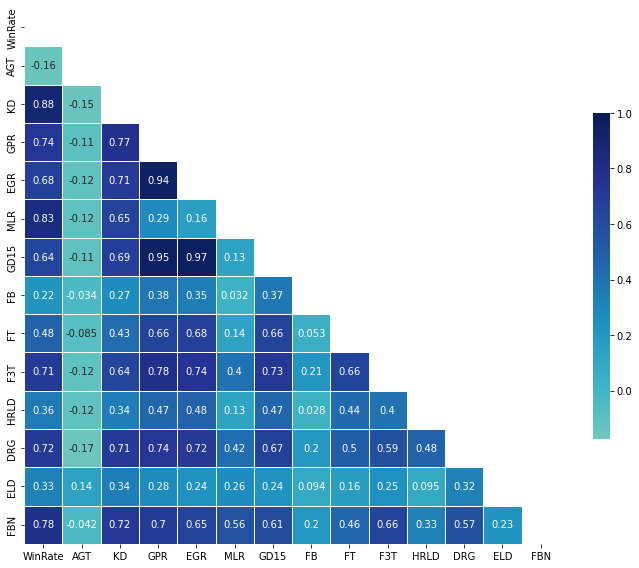

In [3]:
team_corr = team_clean.corr()
team_corr_matrix = team_corr.values

mask = np.zeros_like(team_corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(team_corr, mask=mask, cmap="YlGnBu", vmax=1.0,annot=True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Which features have poor correlation with winrate? I should remove these.

In [4]:
train, test = train_test_split (team_clean, test_size = .25, random_state=7)

# Remove Average game time and first blood because they have low correlation to winrate.
corr = train[train.columns[1:]].apply(lambda x: x.corr(train['WinRate']))
cols = []
for col in corr.index:
    if (corr[col]>0.3 or corr[col]<-0.3):
        cols.append(col)
        
print("These features significantly contribute to winrate: ", cols)

These features significantly contribute to winrate:  ['KD', 'GPR', 'EGR', 'MLR', 'GD15', 'FT', 'F3T', 'HRLD', 'DRG', 'ELD', 'FBN']


In [5]:
# Removing insignificant columns for use later.
team_clean_sig = team_clean.drop(['AGT', 'FB'], axis=1)

# Need to make sure my test data has the same number of features as my training/validation data. 
testcols = cols + ['WinRate']

test = test[testcols]
df_new = train[cols]
df_new.head()

,KD,GPR,EGR,MLR,GD15,FT,F3T,HRLD,DRG,ELD,FBN
37,0.72,-0.59,38.8,-5.5,-1155,28.0,28.0,40.0,39.0,44.0,44.0
28,0.72,-1.16,43.3,-6.9,-978,55.0,27.0,64.0,46.0,0.0,27.0
65,1.53,0.66,58.5,19.2,674,67.0,72.0,75.0,55.0,50.0,78.0
138,1.52,1.53,76.9,-10.2,2096,89.0,78.0,78.0,64.0,0.0,67.0
66,0.78,-0.44,43.7,-16.0,-415,39.0,50.0,50.0,35.0,20.0,28.0


## Standardize the data

In [6]:
scaler = MinMaxScaler()
scaler.fit(df_new)
scaled_features = scaler.transform(df_new)
# Convert to table format - MinMaxScaler
df_MinMax = pd.DataFrame(data=scaled_features, columns=['KD', 'GPR', 'EGR', 'MLR', 'GD15', 'FT', 'F3T', 
                                                        'HRLD', 'DRG', 'ELD', 'FBN'])
df_MinMax.head()

,KD,GPR,EGR,MLR,GD15,FT,F3T,HRLD,DRG,ELD,FBN
0,0.184080,0.299559,0.246353,0.588057,0.292441,0.297872,0.28,0.40,0.349206,0.44,0.488889
1,0.184080,0.174009,0.319287,0.573887,0.321277,0.585106,0.27,0.64,0.460317,0.00,0.300000
2,0.587065,0.574890,0.565640,0.838057,0.590420,0.712766,0.72,0.75,0.603175,0.50,0.866667
3,0.582090,0.766520,0.863857,0.540486,0.822092,0.946809,0.78,0.78,0.746032,0.00,0.744444
4,0.213930,0.332599,0.325770,0.481781,0.413001,0.414894,0.50,0.50,0.285714,0.20,0.311111


## Train and test the Linear Regression model

In [7]:
X = df_MinMax
y = train['WinRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 7)

m = LinearRegression()

m.fit(X_train, y_train)
print(m.predict(X_test))
print("Score: ", m.score(X_train, y_train))

[ 0.33420488  0.00143259  0.34881954  0.55491956  0.33392667  0.60028216
  0.54247923  0.2492291   0.249802    0.49971928  0.63655816  0.75223943
  0.24976776  0.61050036  0.00156303  0.83269735  0.66702907  0.3106003
  0.3868091   0.37501865  0.75107744  0.32597057  0.45474904  0.853373
  0.63680926  0.52753983  0.22209929  0.57265375  0.44598661  0.66661217
  0.27707592  0.49968065 -0.00158615  0.50036121  0.76769132  0.52654855
  0.1668788   0.56793495  0.39930474  0.52879417  0.4996619   0.58370689
  0.40053561  0.45400485]
Score:  0.9998922376044952


## Run the model on the finals dataframe

In [8]:
finals_select = pd.DataFrame(data = finals_clean, columns=['KD', 'GPR', 'EGR', 'MLR', 'GD15', 'FT', 'F3T','HRLD', 'DRG', 'ELD', 'FBN'])

scaler = MinMaxScaler()
scaler.fit(finals_select)
scaled_features = scaler.transform(finals_select)
# Convert to table format - MinMaxScaler
finals_MinMax = pd.DataFrame(data=scaled_features, columns=['KD', 'GPR', 'EGR', 'MLR', 'GD15', 'FT', 'F3T','HRLD', 'DRG', 'ELD', 'FBN'])


X = finals_MinMax
y = finals_clean['WinRate']

m.fit(X, y)
m.predict(X)
print("Score: ", m.score(X, y))

Score:  0.9999992784150938


## Performing K-Means Clustering

In [9]:
# Defining a function to run k-means clustering with given parameters
def kmeans_func(n_clusters, df, x, y):
    km = KMeans(n_clusters, init='random', tol=0.000001, max_iter=300, n_init=10, random_state=0)
    km.fit(df)
    
    cs = np.round(km.cluster_centers_, n_clusters)
    
    plt.scatter(df[x], df[y], c= km.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(cs[:, 0], cs[:, 1], c='red', s=50)
    plt.show()
    
    
    # Evaluating the performance utilizing silhouette_score
    s_score = silhouette_score(team_clean, km.labels_)
    print("Silhouette scores: " + str(s_score))

The Elbow Method is extremely useful in helping to determine a proper k-value for a given dataset.

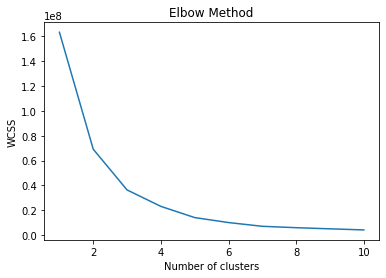

In [10]:
# Setting up the Elbow Method.
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', tol=0.000001, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(team_clean_sig)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
# It appears that 5 clusters would be enough in this case.

It looks like the model can accurately predict winrate from these features, even when it has not been trained on any data from this competitive season.

## Graph the linear regressions

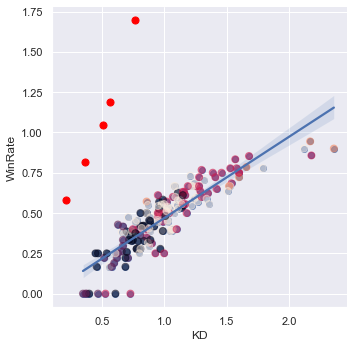

Silhouette scores: 0.5315370579957279


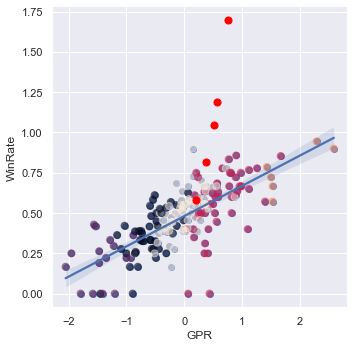

Silhouette scores: 0.5315370579957279


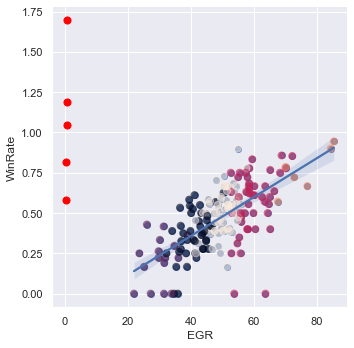

Silhouette scores: 0.5315370579957279


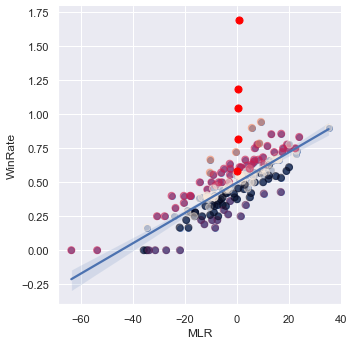

Silhouette scores: 0.5315370579957279


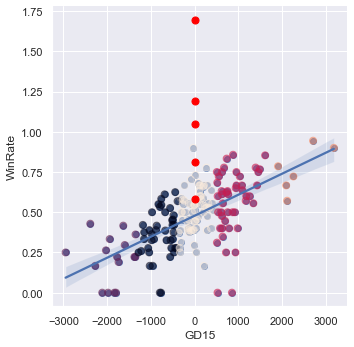

Silhouette scores: 0.5315370579957279


In [11]:
sns.set_theme(color_codes=True)

sns.lmplot(x="KD", y="WinRate", data=team_clean);
kmeans_func(5, team_clean_sig, "KD", "WinRate")
sns.lmplot(x="GPR", y="WinRate", data=team_clean);
kmeans_func(5, team_clean_sig, "GPR", "WinRate")
sns.lmplot(x="EGR", y="WinRate", data=team_clean);
kmeans_func(5, team_clean_sig, "EGR", "WinRate")
sns.lmplot(x="MLR", y="WinRate", data=team_clean);
kmeans_func(5, team_clean_sig, "MLR", "WinRate")
sns.lmplot(x="GD15", y="WinRate", data=team_clean);
kmeans_func(5, team_clean_sig, "GD15", "WinRate")

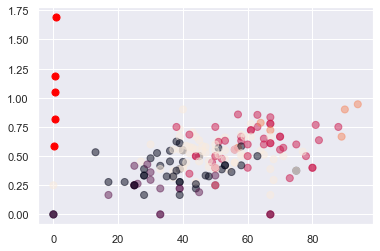

Silhouette scores: 0.5315370579957279


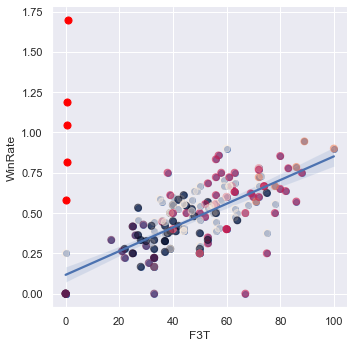

Silhouette scores: 0.5315370579957279


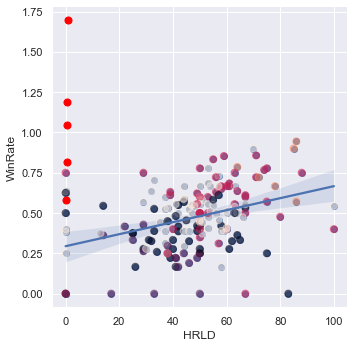

Silhouette scores: 0.5315370579957279


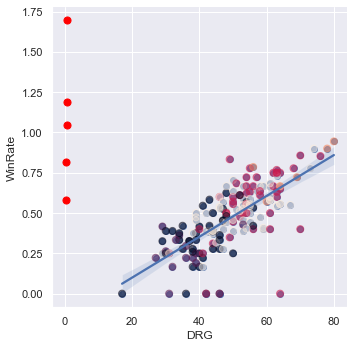

Silhouette scores: 0.5315370579957279


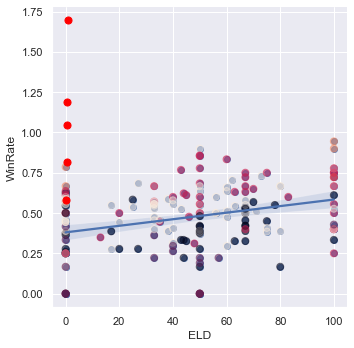

Silhouette scores: 0.5315370579957279


In [12]:
kmeans_func(5, team_clean_sig, "FT", "WinRate")
sns.lmplot(x="F3T", y="WinRate", data=team_clean);
kmeans_func(5, team_clean_sig, "F3T", "WinRate")
sns.lmplot(x="HRLD", y="WinRate", data=team_clean);
kmeans_func(5, team_clean_sig, "HRLD", "WinRate")
sns.lmplot(x="DRG", y="WinRate", data=team_clean);
kmeans_func(5, team_clean_sig, "DRG", "WinRate")
sns.lmplot(x="ELD", y="WinRate", data=team_clean);
kmeans_func(5, team_clean_sig, "ELD", "WinRate")

### Clustering is odd for ELD as the objective didn't exist in early seasons of the LCS. 

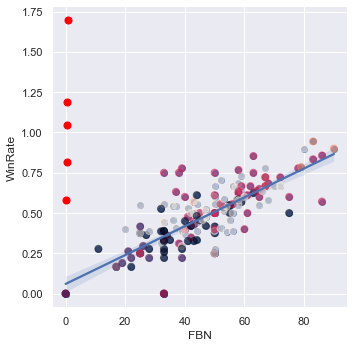

Silhouette scores: 0.5315370579957279


In [13]:
sns.lmplot(x="FBN", y="WinRate", data=team_clean);
kmeans_func(5, team_clean_sig, "FBN", "WinRate")

### It looks like First Tower is less correlated than First to 3 Towers.  Herald and Elder stats also seem to have very little correlation with winrate. 

## Test out another model

In [14]:
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)
print(regr.predict(X_test))
print("Score: ", regr.score(X_train, y_train))

[0.31790004 0.27712356 0.3603789  0.56388675 0.37830867 0.59026453
 0.4907306  0.301693   0.299915   0.42077311 0.59152769 0.70478944
 0.26744003 0.49634044 0.21202622 0.75305214 0.6265173  0.36023641
 0.37630463 0.36097645 0.66849348 0.36226539 0.39110718 0.75156175
 0.66216718 0.50103401 0.2656555  0.58254938 0.45547789 0.664311
 0.33501774 0.48600173 0.06759259 0.44600745 0.65454878 0.49556842
 0.23164708 0.52321824 0.36791584 0.50396977 0.52356481 0.49731905
 0.53680856 0.45719846]
Score:  0.9860857218508673


Random Forest Regression does not perform as well as Linear Regression. Perhaps this is because there is not enough data for significantly large decision trees?

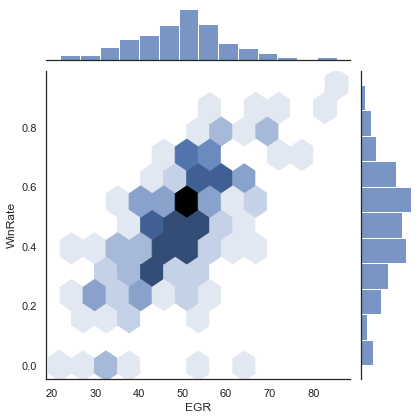

In [15]:
with sns.axes_style('white'):
    sns.jointplot("EGR", "WinRate", team_clean, kind='hex')

## Import matchups datasets and create dataframes

In [16]:
#Contains the list of teams and previous results
lcs=pd.read_csv('FinalFiles/lcs.csv')
#Contains specific match data from the 2022 lcs regular season 
result=pd.read_csv('FinalFiles/result.csv')
#Contains playoff schedule
matchups=pd.read_csv('FinalFiles/matchups.csv')
#Contains ranking of all teams based off regular season finishing
ranking=pd.read_csv('FinalFiles/ranking.csv')

## Reconfigure the dataframes to prep logistic regression

In [17]:
#List of all LCS teams
lcs_teams=['100 Thieves', 'Cloud9', 'Counter Logic Gaming', 'Dignitas', 'Evil Geniuses', 'FlyQuest'
               'Golden Guardians', 'Team Liquid']
team1=result[result['Team_1'].isin(lcs_teams)]
team2=result[result['Team_2'].isin(lcs_teams)]
teams=pd.concat((team1,team2))
teams=teams.drop_duplicates()

team_result=teams.drop(['date'],axis=1)
#Create a data matrix of matchups
final_result= pd.get_dummies(team_result, prefix=['Team_1', 'Team_2'], columns=['Team_1', 'Team_2'])

## Run logistic regression

In [18]:
X=final_result.drop(['Winner'],axis=1)
y=final_result['Winner']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=42)

model=LogisticRegression()
model.fit(X_train,y_train)
train_score=model.score(X_train,y_train)
test_score=model.score(X_test,y_test)
print("Training accuracy: ", train_score)
print("Testing accuracy: ", test_score)

Training accuracy:  0.8414634146341463
Testing accuracy:  0.7777777777777778


## Run the matchups and store the results

In [19]:
matchups.insert(1,'Team_1_position',matchups['Team_1'].map(ranking.set_index('Team')['Position']))
matchups.insert(2,'Team_2_position',matchups['Team_2'].map(ranking.set_index('Team')['Position']))
fixture=matchups.iloc[:45,:]

final_set=fixture[['Team_1','Team_2']]
final_set = pd.get_dummies(final_set, prefix=['Team_1', 'Team_2'], columns=['Team_1', 'Team_2'])
for col in (set(final_result.columns)-set(final_set.columns)):
    final_set[col]=0
final_set=final_set.sort_index(axis=1)
final_set=final_set.drop(['Winner'],axis=1)

In [20]:
prediction=model.predict(final_set)

## Show the matchups and results

In [21]:
for index,tuples in fixture.iterrows():
    counter = 0
    if(index==0):
        print("Start of Playoffs")
    if(index==4):
        print("\n\nStart of Semi-Finals")
    if(index==6):
        print("\n\nStart of Finals")
    print("Teams: " + tuples['Team_1']+ " and " + tuples['Team_2'])
    print("Winner: "+ prediction[index])   

Start of Playoffs
Teams: Team Liquid and Counter Logic Gaming
Winner: Team Liquid
Teams: 100 Thieves and Dignitas
Winner: Dignitas
Teams: Cloud9 and Golden Guardians
Winner: Cloud9
Teams: Evil Geniuses and FlyQuest
Winner: Evil Geniuses


Start of Semi-Finals
Teams: Team Liquid and Evil Geniuses
Winner: Team Liquid
Teams: Cloud9 and 100 Thieves
Winner: 100 Thieves


Start of Finals
Teams: Team Liquid and 100 Thieves
Winner: Team Liquid


## Model vs reality graphic

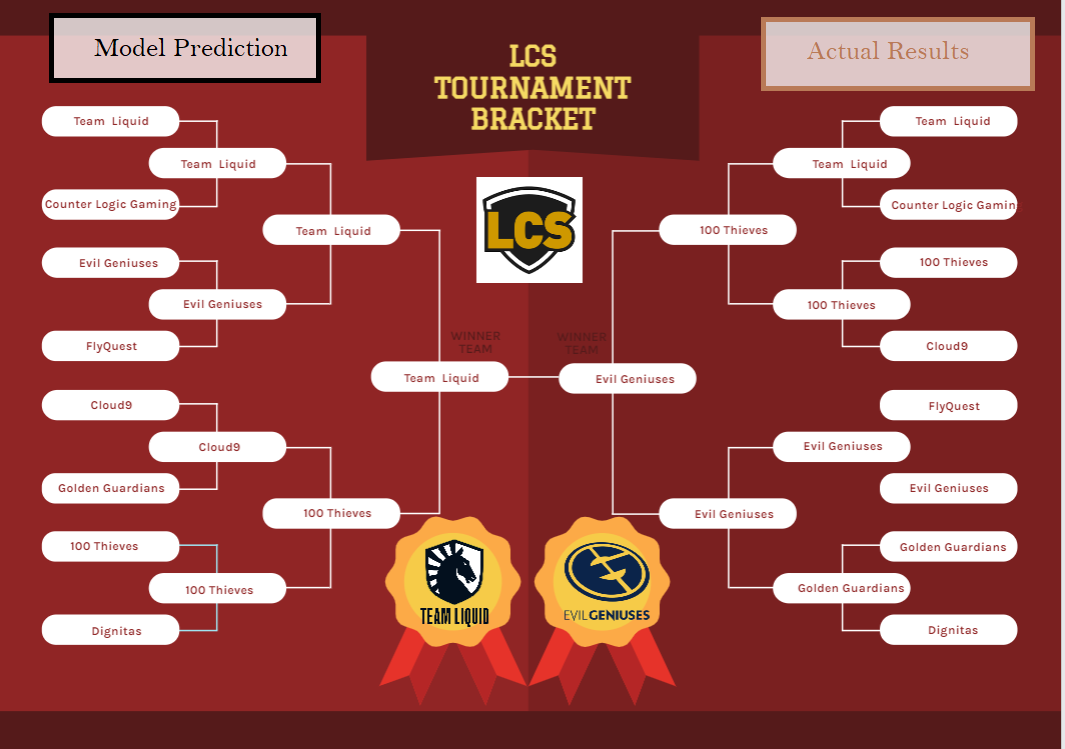

In [22]:
display.Image("FinalFiles/ModelPredvsActual.png")

## Observations

Utilizing a large dataset from multiple seasons of the LCS allowed me to produce far more accurate results despite the changes in the game itself throughout each year. The initial correlation matrix made it clear that some features are close to zero correlation with a team's winrate. After removing such variables, the accuracy of the model greatly increased. In fact, the score of our linear regression analysis was nearly 100%, meaning the predictive power of the model is extremely high. K-means clustering allowed me to further confirm correlations between each variable and overall winrate through graphical visualizations. Our usage of logistic regression on the most recent season's matchups resulted in relatively decent predictions given the limited set of data. Regardless of past statistics, there's always a chance that a player will perform different individually when it matters the most (playoffs). This typically results in high variance regardless of past data.

## Conclusion

Just as in traditional sports, there will always will be a randomness factor in match prediction. However, esports match predictions can be a bit more accurate as games contain a plethora of data to pull from as it's already stored in the games database. Further detail could certainly be added to our models to increase accuracy based on a variety of minor details from each match. For instance, individual player performance on a particular champion and the overall composition of any particular team greatly affects the outcome of a match as well. In fact, with 159 champions in the game and two teams of 5 different champions, you’re looking at 3.7 X 10^21 of possible team versus team matchups (not to mention the selection of items each player has). Given the seemingly endless number of possible variable combinations for any particular match, our model performs quite well.